# 200 hPa Geopotential Heights and Winds

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import metpy.calc as mpcalc
from metpy.units import units
import cmocean
import cmocean.cm as cmo
from scipy.ndimage import gaussian_filter


In [3]:
# Import my modules
sys.path.append('/Users/tessamontini/repos/montini-phd/modules/')

# Root directories
savedir = '/Users/tessamontini/Desktop/res/'
datadir = '/Users/tessamontini/Google_Drive/DATA/'

### Data

### SALLJ days

In [4]:
# Daily SALLJ time series

infile = datadir + 'sallj/erai.llj.day.1979-2016.csv'
df = pd.read_csv(infile)

# Create column `llj1` where: 0=No LLJ; 1=LLJ at SC or MA
idx = (df['llj_sc'] > 0) | (df['llj_ma'] > 0)
df['llj1'] = 0
df.loc[idx, 'llj1'] = 1

df.head()

,year,mon,day,llj_sc,llj_ma,llj1
0,1979,1,1,1,0,1
1,1979,1,2,1,0,1
2,1979,1,3,0,0,0
3,1979,1,4,0,0,0
4,1979,1,5,0,0,0


### ERA5 renalysis: 200 hPa

* 200hPa geopotential height (zg)
* 200hPa u wind (ua)
* 200hPa v wind (va)

In [5]:
# datafiles
f1 = xr.open_dataset(datadir+'ERA5/day/era5_zg_200_day_1979-2016_spac.nc')
f2 = xr.open_dataset(datadir+'ERA5/day/era5_ua_200_day_1979-2016_spac.nc')
f3 = xr.open_dataset(datadir+'ERA5/day/era5_va_200_day_1979-2016_spac.nc')

# merge into single dataset
era = xr.merge([f1,f2,f3])

print(era, '\n')

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 13880)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    zg         (time, latitude, longitude) float32 ...
    ua         (time, latitude, longitude) float32 ...
    va         (time, latitude, longitude) float32 ... 



In [6]:
# Add llj time series to ERA ds
era['llj1'] = ('time', df.llj1)
era = era.set_coords('llj1')

# Select subset of DJF LLJ days
idx = (era.time.dt.season == 'DJF') & (era.llj1 >= 1)
era_llj = era.sel(time=idx)

print(era_llj)

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 1184)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
    llj1       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    zg         (time, latitude, longitude) float32 ...
    ua         (time, latitude, longitude) float32 ...
    va         (time, latitude, longitude) float32 ...


### SALLJ days by category

In [8]:
# SALLJ days by type
infile = savedir + 'sallj_types_exp5.csv'
dftype = pd.read_csv(infile)

dftype.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184 entries, 0 to 1183
Data columns (total 3 columns):
Unnamed: 0        1184 non-null object
llj_types         1184 non-null int64
llj_types_vrot    1184 non-null int64
dtypes: int64(2), object(1)
memory usage: 27.9+ KB


In [10]:
# Compute composites of each SALLJ type

# add LLJ type time series to ERA dataset
era_llj['llj_types'] = ('time', dftype.llj_types)
era_llj = era_llj.set_coords('llj_types')

print(era_llj)

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 1184)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
    llj1       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    llj_types  (time) int64 2 2 2 2 2 2 2 1 1 2 2 1 ... 2 2 1 3 3 1 2 3 3 1 3 3
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    zg         (time, latitude, longitude) float32 ...
    ua         (time, latitude, longitude) float32 ...
    va         (time, latitude, longitude) float32 ...


In [11]:
# compute mean of each llj_types
era_llj_comp = era_llj.groupby('llj_types').mean('time')

print(era_llj_comp)

<xarray.Dataset>
Dimensions:    (latitude: 161, llj_types: 3, longitude: 307)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * llj_types  (llj_types) int64 1 2 3
Data variables:
    zg         (llj_types, latitude, longitude) float32 12355.196 ... 11300.978
    ua         (llj_types, latitude, longitude) float32 20.968801 ... 12.068152
    va         (llj_types, latitude, longitude) float32 -8.192061 ... 1.7757953


In [ ]:
#ann200 = era200_llj.groupby('time.year')
#print(ann200)

### Map:  200hPa geopotential height and winds

In [18]:
# Data for plotting
lats = era_llj_comp.latitude.values
lons = era_llj_comp.longitude.values
hgts = era_llj_comp.zg.values
uwnd = era_llj_comp.ua.values * units('m/s')
vwnd = era_llj_comp.va.values * units('m/s')
wspd = mpcalc.wind_speed(uwnd, vwnd)
wspd_kt = wspd.to('kt')

# Labels
type_label = ['LLJ Type 1', 'LLJ Type 2', 'LLJ Type 3']

# Figure set up
nplots = 3
nrows = 3
ncols = 1

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()


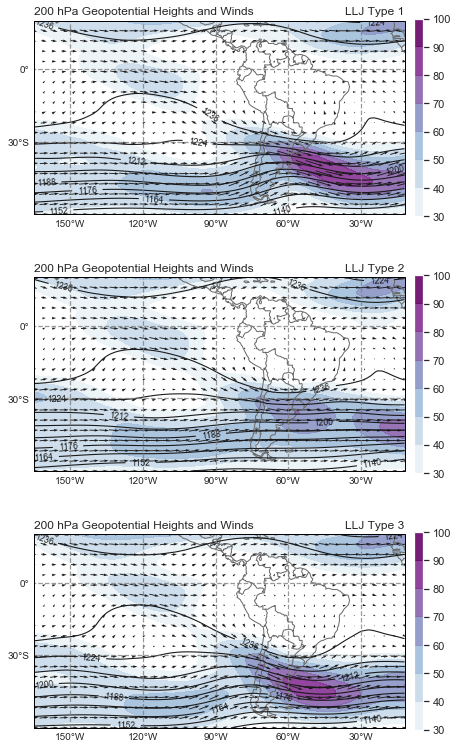

In [26]:
# Create figure
fig = plt.figure(figsize=(8,11))
gs = GridSpec(3, 1, figure=fig, hspace=0.04, top=0.97, bottom=0.01)

# Loop through each subplot 
for k in range(nplots):
      
    # Add plot axes 
    ax = fig.add_subplot(gs[k,0], projection=mapcrs)
    
    # Set plot boundaries
    ax.set_extent([-165, -12, -60, 20], crs=mapcrs)
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, edgecolor='dimgrey')
    ax.add_feature(cfeature.BORDERS, edgecolor='dimgrey')
    
    # Wind Speed (contour filled)
    clevs_wspd = np.arange(30,101,10)
    cf = ax.contourf(lons, lats, wspd_kt[k,:,:], transform=datacrs,
                     levels=clevs_wspd, cmap='BuPu', alpha=0.9)
   # cb = plt.colorbar(cf, orientation='horizontal', pad=0.02, aspect=40) # horizontal cb
    cb = plt.colorbar(cf, orientation='vertical', pad=0.02, shrink=0.8)
   # cb.set_label('kt')
    
    # Geopotenital height lines
    clevs_hgts = np.arange(1080,1280,12)
    cs = ax.contour(lons, lats, hgts[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5)    
        
    # Wind barbs / vectors 
    ax.quiver(lons, lats, uwnd[k,:,:], vwnd[k,:,:], transform=datacrs, 
             color='k', regrid_shape=20, pivot='middle')
   
    # subtitles
    ax.set_title(type_label[k], loc='right')
    ax.set_title('200 hPa Geopotential Heights and Winds', loc='left')
    
    # gridlines
    dx = np.arange(-180,31,30)
    dy = np.arange(-60,61,30)
    gl = ax.gridlines(crs=mapcrs, draw_labels=True, linewidth=1.25, color='grey', linestyle='--', alpha=0.8) #alpha
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(dx)
    gl.ylocator = mticker.FixedLocator(dy)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

       
# Display figure
plt.savefig(savedir+'comp-llj-200hpa.png', dpi=350)
plt.show()